In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing necessary Libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.metrics import BinaryAccuracy, Precision,Recall
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,InputLayer,BatchNormalization,Activation, Input,Dropout,GlobalAveragePooling2D,MaxPooling2D,Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
from tensorflow.keras.losses import BinaryCrossentropy

import wandb
from wandb.keras import WandbCallback 

from tensorflow.keras.utils import plot_model
from IPython.display import Image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# DataSet Creation

In [2]:
train_directory = '//kaggle/input/cub-fake-real-dataset/data/train'
validation_directory = '/kaggle/input/cub-fake-real-dataset/data/val'

CLASS_NAMES = ['fake','real']

### Setting Our Configuration for the model

In [3]:
CONFIGURATION ={
    "BATCH_SIZE":32,
    "IM_SIZE" :64,
    'DROPOUT_RATE':0.0,
    "N_EPOCHS": 20,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES":2,
    "LEARNING_RATE":0.001,
    "PATCH_SIZE":16
}

#### Importing datasets and storing them in train and validation dataset

In [4]:
training_dataset = tf.keras.utils.image_dataset_from_directory(
    directory = train_directory,
    labels = 'inferred',
    label_mode = 'binary',
    class_names = CLASS_NAMES,
    color_mode = 'rgb',
    batch_size = CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"] ),
    shuffle=True,
    seed=99,
)

Found 8396 files belonging to 2 classes.


In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    directory = validation_directory,
    labels = 'inferred',
    label_mode = 'binary',
    class_names = CLASS_NAMES,
    color_mode = 'rgb',
    batch_size = CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"] ),
    shuffle=True,
    seed=99,
)

Found 2798 files belonging to 2 classes.


Checking if dataset has been prepared correctly

In [ ]:
# Printing first element of first batch
for i in training_dataset.take(1):
    print(i)
    

# Data Visualization

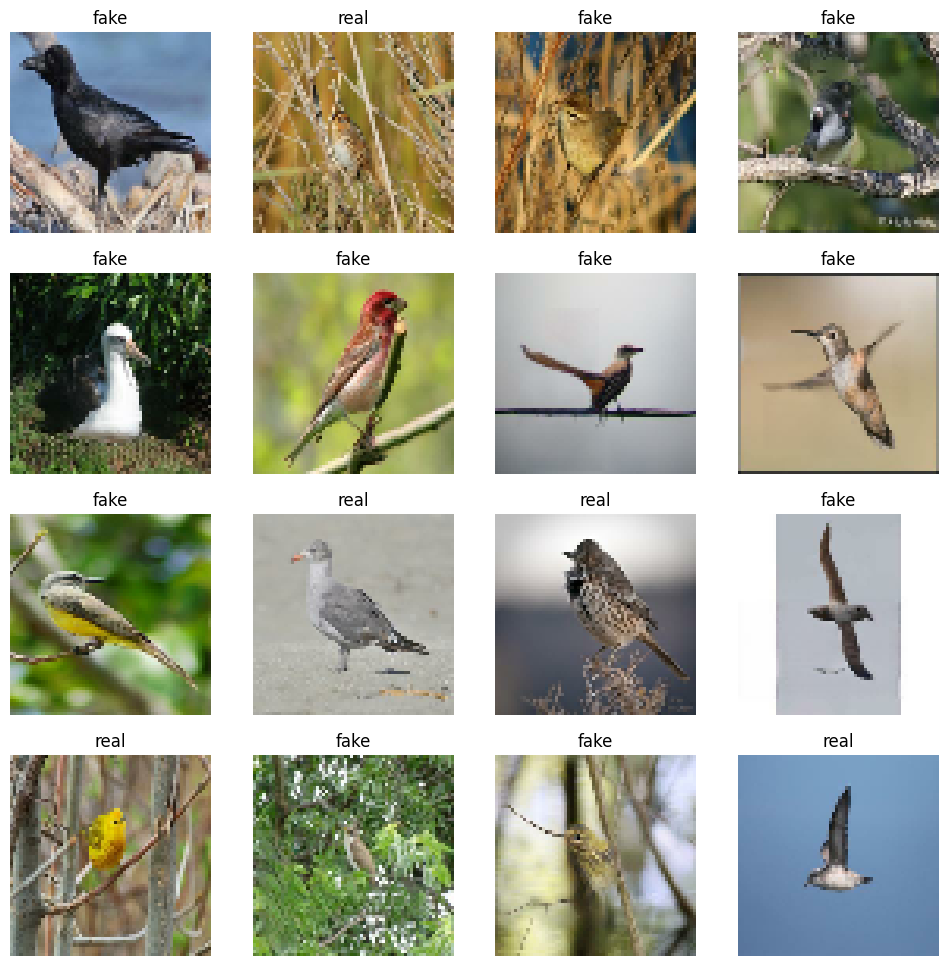

In [7]:
plt.figure(figsize = (12,12))
for image, label in training_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(image[i]/255.)
        plt.title(CLASS_NAMES[int(label[i])])
        plt.axis('off')

# DataSet Preparation

In [8]:
training_dataset = (
    training_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [9]:
validation_dataset = (
    validation_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [10]:
training_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

# Designing Callbacks for Model

In [12]:
# Customized Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch <= 10:
        return 0.001
    elif epoch<= 25:
        return 0.0001
    else:
        return lr * tf.math.exp(-0.1)

scheduler_callback = LearningRateScheduler(scheduler,verbose=1)
    

In [13]:
# Reduce LR On no Improvement
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.1,
    patience = 1,
    verbose = 1,
    mode = 'min',
    min_delta = 0.000001,
    cooldown = 0,
    min_lr = 1e-15,
)

In [14]:
# Model Checkpointing
model_checkpoint = ModelCheckpoint(
    '/kaggle/working/CNN_checkpoint',
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
    mode = 'min',
    save_freq='epoch',
)

## Wandb
Using wandb to track performance of the model

In [115]:
!wandb login 

wandb: Currently logged in as: devasurya. Use `wandb login --relogin` to force relogin


In [116]:
wandb.init(project='Real-vs-Fake-Image-Classification',entity="technopath2003")

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/wandb_init.py", line 1154, in init
    wandb._assert_is_user_process()
  File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/wandb_init.py", line 770, in init
    run_init_handle._cancel()
wandb.errors.CommError: Run initialization has timed out after 60.0 sec. 
Please refer to the documentation for additional information: https://docs.wandb.ai/guides/track/tracking-faq#initstarterror-error-communicating-with-wandb-process-

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/wandb_init.py", line 1162, in init
    wi.setup(kwargs)
  File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/wandb_init.py", line 837, in getcaller
    self.backend = backend
  File "/root/.local/lib/python3.10/site-packages/log.py", line 42, in findCaller
    sio = io.StringIO()
NameError: name 'io' is no

Error: An unexpected error occurred

In [ ]:
wandb.config = {
    "BATCH_SIZE":32,
    "IM_SIZE" :64,
    'DROPOUT_RATE':0.0,
    "N_EPOCHS": 20,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES":2,
    "LEARNING_RATE":0.001,
    "PATCH_SIZE":16
}

In [ ]:
CONFIGURATION = wandb.config

# Model Creation

In [23]:
metrics = [BinaryAccuracy(name='Accuracy'),Precision(name='Precision'),Recall(name='Recall')]

In [ ]:
!pip install --upgrade -q wandb

In [ ]:
# from kaggle_secrets import UserSecretsClient

# user_secrets = UserSecretsClient()

# # I have saved my API token with "wandb_api" as Label. 
# # If you use some other Label make sure to change the same below. 
# wandb_api = user_secrets.get_secret("9c038d2c80abd94614b7c625c8c17cff4c9832d6") 

wandb.login()

### ResNet_34

In [ ]:
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="uiui",
    
#     # track hyperparameters and run metadata
#     config={
#     "learning_rate": 0.02,
#     "architecture": "CNN",
#     "dataset": "CIFAR-100",
#     "epochs": 10,
#     }
# )

In [37]:
wandb.init(project='rvf')

In [38]:
wandb.config = {
    "BATCH_SIZE":32,
    "IM_SIZE" :64,
    'DROPOUT_RATE':0.0,
    "N_EPOCHS": 20,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES":2,
    "LEARNING_RATE":0.001,
    "PATCH_SIZE":16
}

CONFIGURATION = wandb.config

In [39]:
# Model Checkpointing
model_checkpoint = ModelCheckpoint(
    '/kaggle/working/ResNet34_checkpoint',
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
    mode = 'min',
    save_freq='epoch',
)

In [40]:
class CustomConv2D(Layer):
    def __init__(self,n_filters,kernel_size,n_strides,padding = 'valid'):
        super(CustomConv2D,self).__init__(name = 'custom_conv2d')
        
        self.conv = Conv2D(
            filters = n_filters,
            kernel_size = kernel_size,
            activation = 'relu',
            strides = n_strides,
            padding = padding)
        
        self.batch_norm = BatchNormalization()
        
    def call(self,x,training = True):
        
        x = self.conv(x)
        x = self.batch_norm(x)
        
        return x

In [41]:
class ResidualBlock(Layer):
    def __init__(self,n_channels,n_strides=1):
        super(ResidualBlock,self).__init__(name = 'res_block')
        
        self.dotted = (n_strides != 1)
        
        self.custom_conv_1 = CustomConv2D(n_channels,3,n_strides,padding = 'same')
        self.custom_conv_2 = CustomConv2D(n_channels,3,1,padding = 'same')
        
        self.activation = Activation('relu')
        
        if self.dotted:
            self.custom_conv_3 = CustomConv2D(n_channels,1,n_strides)
        
    def call(self, input,training):
        x = self.custom_conv_1(input,training)
        x = self.custom_conv_2(x,training)
        
        if self.dotted:
            x_add = self.custom_conv_3(input,training)
            x_add = Add()([x,x_add])
        else :
            x_add = Add()([x,input])
        
        return self.activation(x_add)

In [42]:
class ResNet34(Model):
    def __init__(self,):
        super(ResNet34,self).__init__(name = 'resnet_34')
        
        self.conv_1 = CustomConv2D(64,7,2,padding = 'same')  # 7 kernel, 2 stride
        self.max_pool = MaxPooling2D(3,2) # 3x3 , 2 stride
        
        self.conv_2_1 = ResidualBlock(64)
        self.conv_2_2 = ResidualBlock(64)
        self.conv_2_3 = ResidualBlock(64)
        
        self.conv_3_1 = ResidualBlock(128,2) 
        self.conv_3_2 = ResidualBlock(128)
        self.conv_3_3 = ResidualBlock(128)
        self.conv_3_4 = ResidualBlock(128)
        
        self.conv_4_1 = ResidualBlock(256,2) 
        self.conv_4_2 = ResidualBlock(256)
        self.conv_4_3 = ResidualBlock(256)
        self.conv_4_4 = ResidualBlock(256)
        self.conv_4_5 = ResidualBlock(256)
        self.conv_4_6 = ResidualBlock(256)
        
        self.conv_5_1 = ResidualBlock(512,2) 
        self.conv_5_2 = ResidualBlock(512)
        self.conv_5_3 = ResidualBlock(512)
        
        self.global_pool = GlobalAveragePooling2D()
        
        self.fc_3 = Dense(1,activation = 'sigmoid')
        
    def call(self,x,training):
        x = self.conv_1(x)
        x = self.max_pool(x)
        
        x = self.conv_2_1(x,training)
        x = self.conv_2_2(x,training)
        x = self.conv_2_3(x,training)
        
        x = self.conv_3_1(x,training)
        x = self.conv_3_2(x,training)
        x = self.conv_3_3(x,training)
        x = self.conv_3_4(x,training)
        
        x = self.conv_4_1(x,training)
        x = self.conv_4_2(x,training)
        x = self.conv_4_3(x,training)
        x = self.conv_4_4(x,training)
        x = self.conv_4_5(x,training)
        x = self.conv_4_6(x,training)
        
        x = self.conv_5_1(x,training)
        x = self.conv_5_2(x,training)
        x = self.conv_5_3(x,training)
        
        x = self.global_pool(x)
        
        return self.fc_3(x)

In [43]:
resnet34_model = ResNet34()
resnet34_model(tf.zeros([1,256,256,3]), training = False)
resnet34_model.summary()

Model: "resnet_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2d (CustomConv2  multiple                  9728      
 D)                                                              
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  23

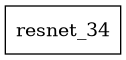

In [44]:
plot_model(resnet34_model, to_file='resnet34_model.png', show_shapes=True,show_layer_names=True)
Image(filename='resnet34_model.png') 

In [45]:
resnet34_model.compile( 
        optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
        loss = BinaryCrossentropy(),
        metrics = metrics
)

#### Model Training

In [46]:
wandb.run

resnet34_model_history = resnet34_model.fit(
    training_dataset, validation_data = validation_dataset,epochs = CONFIGURATION['N_EPOCHS']
    , callbacks = [reduce_lr, model_checkpoint, WandbCallback()]
)

wandb.finish()

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/20
263/263 [==============================] - ETA: 0s - loss: 0.7953 - Accuracy: 0.5146 - Precision: 0.5142 - Recall: 0.5267
Epoch 1: val_loss improved from inf to 0.73565, saving model to /kaggle/working/ResNet34_checkpoint


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231203_170012-uegq6ojm/files/model-best)... Done. 1.0s


263/263 [==============================] - 56s 118ms/step - loss: 0.7953 - Accuracy: 0.5146 - Precision: 0.5142 - Recall: 0.5267 - val_loss: 0.7356 - val_Accuracy: 0.5107 - val_Precision: 0.5401 - val_Recall: 0.1444 - lr: 0.0010
Epoch 2/20
263/263 [==============================] - ETA: 0s - loss: 0.7048 - Accuracy: 0.5509 - Precision: 0.5522 - Recall: 0.5376
Epoch 2: val_loss improved from 0.73565 to 0.71080, saving model to /kaggle/working/ResNet34_checkpoint


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231203_170012-uegq6ojm/files/model-best)... Done. 1.0s


263/263 [==============================] - 29s 110ms/step - loss: 0.7048 - Accuracy: 0.5509 - Precision: 0.5522 - Recall: 0.5376 - val_loss: 0.7108 - val_Accuracy: 0.5665 - val_Precision: 0.5796 - val_Recall: 0.4839 - lr: 0.0010
Epoch 3/20
263/263 [==============================] - ETA: 0s - loss: 0.7228 - Accuracy: 0.5648 - Precision: 0.5658 - Recall: 0.5572
Epoch 3: val_loss improved from 0.71080 to 0.70299, saving model to /kaggle/working/ResNet34_checkpoint


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231203_170012-uegq6ojm/files/model-best)... Done. 1.0s


263/263 [==============================] - 30s 112ms/step - loss: 0.7228 - Accuracy: 0.5648 - Precision: 0.5658 - Recall: 0.5572 - val_loss: 0.7030 - val_Accuracy: 0.5254 - val_Precision: 0.5689 - val_Recall: 0.2094 - lr: 0.0010
Epoch 4/20
262/263 [============================>.] - ETA: 0s - loss: 0.6978 - Accuracy: 0.5844 - Precision: 0.5857 - Recall: 0.5776
Epoch 4: val_loss improved from 0.70299 to 0.68128, saving model to /kaggle/working/ResNet34_checkpoint


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231203_170012-uegq6ojm/files/model-best)... Done. 1.1s


263/263 [==============================] - 29s 112ms/step - loss: 0.6977 - Accuracy: 0.5844 - Precision: 0.5857 - Recall: 0.5772 - val_loss: 0.6813 - val_Accuracy: 0.5751 - val_Precision: 0.5675 - val_Recall: 0.6312 - lr: 0.0010
Epoch 5/20
263/263 [==============================] - ETA: 0s - loss: 0.6856 - Accuracy: 0.6073 - Precision: 0.6065 - Recall: 0.6110
Epoch 5: val_loss improved from 0.68128 to 0.66727, saving model to /kaggle/working/ResNet34_checkpoint


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231203_170012-uegq6ojm/files/model-best)... Done. 0.9s


263/263 [==============================] - 29s 110ms/step - loss: 0.6856 - Accuracy: 0.6073 - Precision: 0.6065 - Recall: 0.6110 - val_loss: 0.6673 - val_Accuracy: 0.6108 - val_Precision: 0.5826 - val_Recall: 0.7813 - lr: 0.0010
Epoch 6/20
262/263 [============================>.] - ETA: 0s - loss: 0.6806 - Accuracy: 0.5960 - Precision: 0.5927 - Recall: 0.6146
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 6: val_loss did not improve from 0.66727
263/263 [==============================] - 10s 39ms/step - loss: 0.6808 - Accuracy: 0.5958 - Precision: 0.5924 - Recall: 0.6141 - val_loss: 0.7627 - val_Accuracy: 0.5043 - val_Precision: 0.6000 - val_Recall: 0.0257 - lr: 0.0010
Epoch 7/20
263/263 [==============================] - ETA: 0s - loss: 0.5947 - Accuracy: 0.6722 - Precision: 0.6687 - Recall: 0.6827
Epoch 7: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 7: val_loss did not improve from 0.66727
263/263 [==================

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231203_170012-uegq6ojm/files/model-best)... Done. 0.9s


263/263 [==============================] - 28s 106ms/step - loss: 0.5529 - Accuracy: 0.7108 - Precision: 0.6983 - Recall: 0.7425 - val_loss: 0.5960 - val_Accuracy: 0.6680 - val_Precision: 0.6485 - val_Recall: 0.7334 - lr: 1.0000e-05
Epoch 9/20
262/263 [============================>.] - ETA: 0s - loss: 0.5468 - Accuracy: 0.7080 - Precision: 0.6939 - Recall: 0.7449
Epoch 9: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 9: val_loss did not improve from 0.59598
263/263 [==============================] - 10s 39ms/step - loss: 0.5474 - Accuracy: 0.7076 - Precision: 0.6934 - Recall: 0.7444 - val_loss: 0.6053 - val_Accuracy: 0.6651 - val_Precision: 0.6285 - val_Recall: 0.8077 - lr: 1.0000e-05
Epoch 10/20
262/263 [============================>.] - ETA: 0s - loss: 0.5416 - Accuracy: 0.7204 - Precision: 0.7031 - Recall: 0.7631
Epoch 10: val_loss improved from 0.59598 to 0.59514, saving model to /kaggle/working/ResNet34_checkpoint


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231203_170012-uegq6ojm/files/model-best)... Done. 1.0s


263/263 [==============================] - 30s 113ms/step - loss: 0.5416 - Accuracy: 0.7205 - Precision: 0.7031 - Recall: 0.7632 - val_loss: 0.5951 - val_Accuracy: 0.6669 - val_Precision: 0.6535 - val_Recall: 0.7105 - lr: 1.0000e-06
Epoch 11/20
263/263 [==============================] - ETA: 0s - loss: 0.5364 - Accuracy: 0.7189 - Precision: 0.7009 - Recall: 0.7637
Epoch 11: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 11: val_loss did not improve from 0.59514
263/263 [==============================] - 11s 40ms/step - loss: 0.5364 - Accuracy: 0.7189 - Precision: 0.7009 - Recall: 0.7637 - val_loss: 0.5956 - val_Accuracy: 0.6655 - val_Precision: 0.6466 - val_Recall: 0.7298 - lr: 1.0000e-06
Epoch 12/20
263/263 [==============================] - ETA: 0s - loss: 0.5353 - Accuracy: 0.7186 - Precision: 0.6987 - Recall: 0.7685
Epoch 12: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 12: val_loss did not improve from 0.59514
263/263 [=====

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231203_170012-uegq6ojm/files/model-best)... Done. 1.0s


263/263 [==============================] - 27s 104ms/step - loss: 0.5406 - Accuracy: 0.7122 - Precision: 0.6939 - Recall: 0.7596 - val_loss: 0.5940 - val_Accuracy: 0.6655 - val_Precision: 0.6479 - val_Recall: 0.7248 - lr: 1.0000e-14
Epoch 20/20
262/263 [============================>.] - ETA: 0s - loss: 0.5379 - Accuracy: 0.7186 - Precision: 0.7004 - Recall: 0.7644
Epoch 20: ReduceLROnPlateau reducing learning rate to 1.0000001518582595e-15.

Epoch 20: val_loss did not improve from 0.59400
263/263 [==============================] - 10s 38ms/step - loss: 0.5379 - Accuracy: 0.7186 - Precision: 0.7002 - Recall: 0.7644 - val_loss: 0.5952 - val_Accuracy: 0.6648 - val_Precision: 0.6469 - val_Recall: 0.7255 - lr: 1.0000e-14


Accuracy,▁▂▃▃▄▄▆▇▇███████████
Precision,▁▂▃▄▄▄▇█████████████
Recall,▁▁▂▂▃▃▅▇▇███████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▆▅▅▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,██████▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_Accuracy,▁▄▂▄▆▁▆█████████████
val_Precision,▁▃▃▃▄▅▃█▆███████████
val_Recall,▂▅▂▆▇▁█▇▇▆▇▇▇▇▇▇▇▇▇▇
val_loss,▇▆▆▅▄█▅▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy,0.71856


#### ResNet_34 Model Evaluation

In [48]:
resnet34_model.load_weights('ResNet34_checkpoint')

In [49]:
resnet34_model.evaluate(validation_dataset)

88/88 [==============================] - 1s 14ms/step - loss: 0.5954 - Accuracy: 0.6640 - Precision: 0.6468 - Recall: 0.7227


[0.5953540205955505,
 0.6640457510948181,
 0.6468330025672913,
 0.7226590514183044]

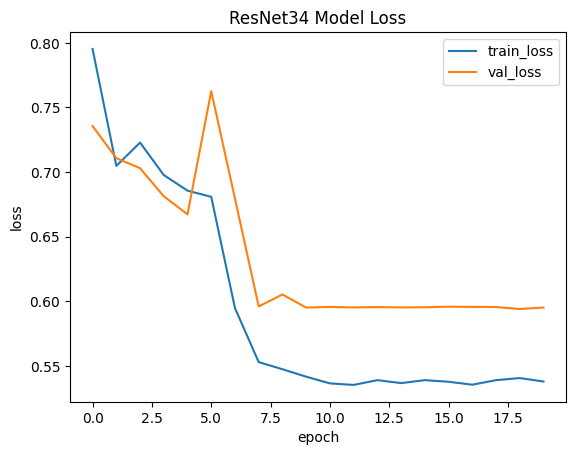

In [50]:
plt.plot(resnet34_model_history.history['loss'])
plt.plot(resnet34_model_history.history['val_loss'])
plt.title('ResNet34 Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss','val_loss'])
plt.show()

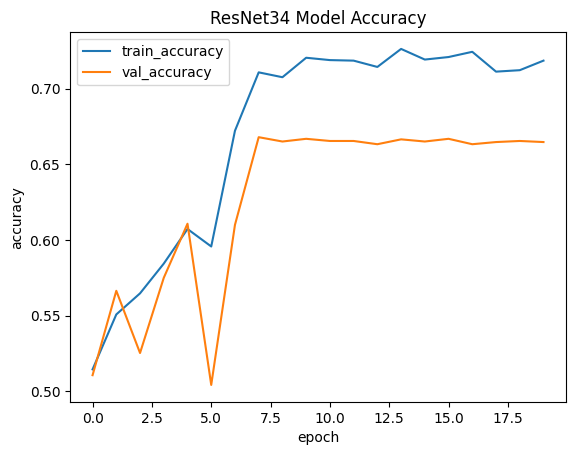

In [51]:
plt.plot(resnet34_model_history.history['Accuracy'])
plt.plot(resnet34_model_history.history['val_Accuracy'])
plt.title('ResNet34 Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

## Using Pretrained Models

### EfficientNetB4

Model has some issues with checkpoint and model_save_weights type of callbacks,
so inorder for them to work you have to downgrade tensorflow with
**!pip install tensorflow==2.9.1**

In [ ]:
wandb.finish()

In [15]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [16]:
wandb.init(project='rvf pretrained')

wandb: Currently logged in as: anumulacs (acs17803). Use `wandb login --relogin` to force relogin


In [17]:
wandb.config = {
    "BATCH_SIZE":32,
    "IM_SIZE" :64,
    'DROPOUT_RATE':0.0,
    "N_EPOCHS": 20,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 2048,
    "N_DENSE_2": 1024,
    "N_DENSE_3": 256,
    "NUM_CLASSES":2,
    "LEARNING_RATE":0.001,
    "PATCH_SIZE":16
}

CONFIGURATION = wandb.config

In [18]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3),
)

71686520/71686520 [==============================] - 0s 0us/step


In [19]:
backbone.trainable = False

In [20]:
efficientnet_b4_model = tf.keras.Sequential([
    Input(shape = (CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3)),
    backbone,
    
    GlobalAveragePooling2D(),
    
    Dense(CONFIGURATION['N_DENSE_1'],activation ='relu'),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION['DROPOUT_RATE']),
    
    Dense(CONFIGURATION['N_DENSE_2'],activation ='relu'),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION['DROPOUT_RATE']),
    
    Dense(CONFIGURATION['N_DENSE_3'],activation ='relu'),
    BatchNormalization(),
    
    Dense(1,activation = 'sigmoid')
])

efficientnet_b4_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional  (None, 2, 2, 1792)        17673823  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1792)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2048)              3672064   
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                        

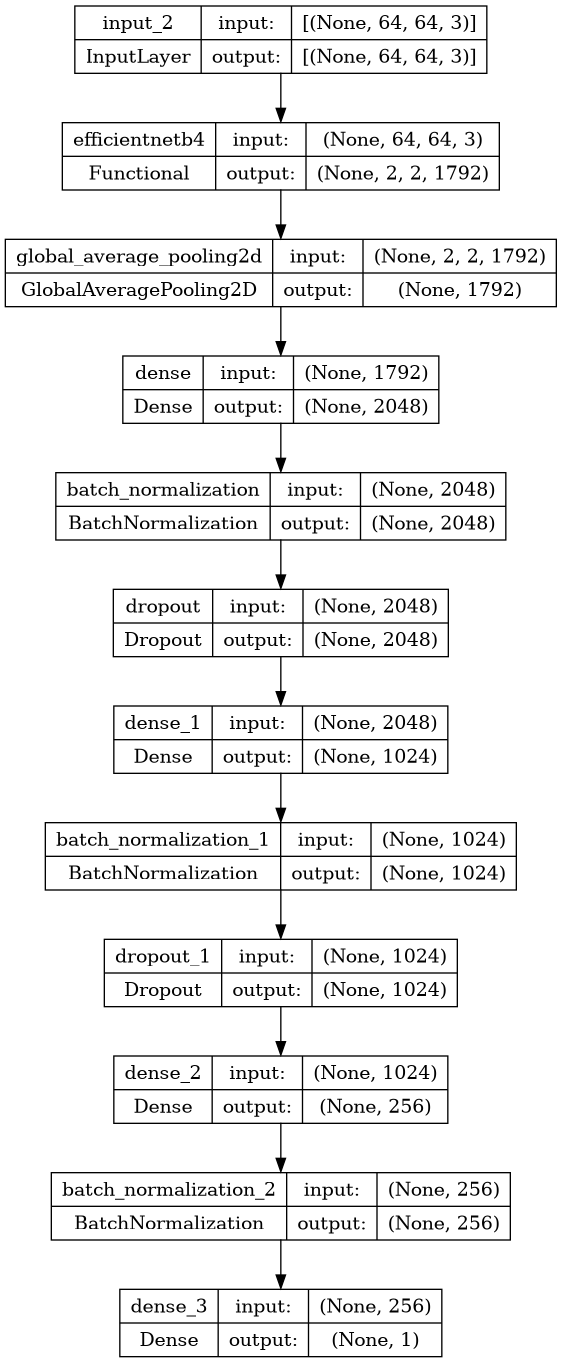

In [21]:
plot_model(efficientnet_b4_model, to_file='efficientnet_b4_model.png', show_shapes=True,show_layer_names=True)
Image(filename='efficientnet_b4_model.png') 

In [24]:
efficientnet_b4_model.compile( 
        optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
        loss = BinaryCrossentropy(),
        metrics = metrics
)

In [25]:
wandb.run

efficientnet_b4_history = efficientnet_b4_model.fit(
    training_dataset, validation_data = validation_dataset,epochs = CONFIGURATION['N_EPOCHS']-5
    , callbacks = [reduce_lr, WandbCallback(save_model=(False))]
)

Epoch 1/15


2023-12-03 16:33:21.175625: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb4/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


263/263 [==============================] - 41s 74ms/step - loss: 0.7765 - Accuracy: 0.5057 - Precision: 0.5057 - Recall: 0.5095 - val_loss: 0.7062 - val_Accuracy: 0.5179 - val_Precision: 0.5187 - val_Recall: 0.4961 - lr: 0.0010
Epoch 2/15
263/263 [==============================] - 8s 30ms/step - loss: 0.6985 - Accuracy: 0.5344 - Precision: 0.5339 - Recall: 0.5422 - val_loss: 0.7039 - val_Accuracy: 0.5229 - val_Precision: 0.5194 - val_Recall: 0.6119 - lr: 0.0010
Epoch 3/15
263/263 [==============================] - 8s 32ms/step - loss: 0.6931 - Accuracy: 0.5410 - Precision: 0.5408 - Recall: 0.5436 - val_loss: 0.6977 - val_Accuracy: 0.5232 - val_Precision: 0.5238 - val_Recall: 0.5111 - lr: 0.0010
Epoch 4/15
262/263 [============================>.] - ETA: 0s - loss: 0.6895 - Accuracy: 0.5543 - Precision: 0.5542 - Recall: 0.5540
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
263/263 [==============================] - 8s 31ms/step - loss: 0.6895 - Accuracy: 0.5

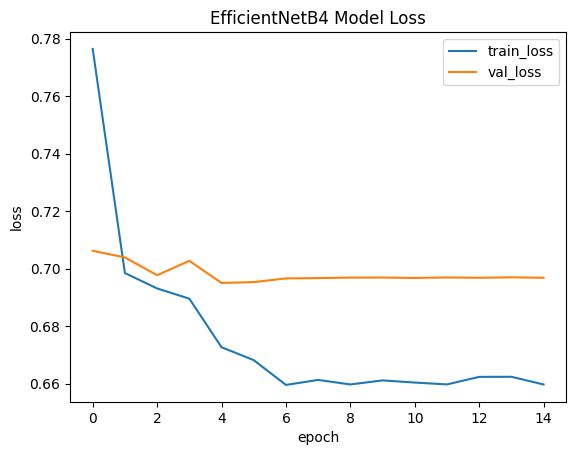

In [26]:
plt.plot(efficientnet_b4_history.history['loss'])
plt.plot(efficientnet_b4_history.history['val_loss'])
plt.title('EfficientNetB4 Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss','val_loss'])
plt.show()

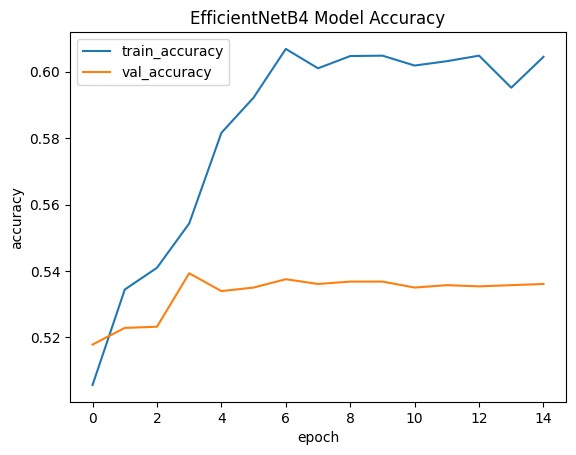

In [27]:
plt.plot(efficientnet_b4_history.history['Accuracy'])
plt.plot(efficientnet_b4_history.history['val_Accuracy'])
plt.title('EfficientNetB4 Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

#### EfficientNetB4 Model Evaluation before Finetuning

Training it for more epochs as accuracy is still increasing

In [28]:
efficientnet_b4_history = efficientnet_b4_model.fit(
    training_dataset, validation_data = validation_dataset,epochs = CONFIGURATION['N_EPOCHS']
    , callbacks = [reduce_lr, WandbCallback(save_model=(False))]
)

Epoch 1/20
263/263 [==============================] - 9s 32ms/step - loss: 0.6577 - Accuracy: 0.6054 - Precision: 0.6036 - Recall: 0.6141 - val_loss: 0.6968 - val_Accuracy: 0.5347 - val_Precision: 0.5337 - val_Recall: 0.5497 - lr: 1.0000e-14
Epoch 2/20
263/263 [==============================] - 8s 31ms/step - loss: 0.6619 - Accuracy: 0.6035 - Precision: 0.6000 - Recall: 0.6212 - val_loss: 0.6967 - val_Accuracy: 0.5357 - val_Precision: 0.5343 - val_Recall: 0.5568 - lr: 1.0000e-14
Epoch 3/20
263/263 [==============================] - ETA: 0s - loss: 0.6616 - Accuracy: 0.6043 - Precision: 0.6008 - Recall: 0.6217
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.0000001518582595e-15.
263/263 [==============================] - 8s 31ms/step - loss: 0.6616 - Accuracy: 0.6043 - Precision: 0.6008 - Recall: 0.6217 - val_loss: 0.6969 - val_Accuracy: 0.5357 - val_Precision: 0.5344 - val_Recall: 0.5554 - lr: 1.0000e-14
Epoch 4/20
263/263 [==============================] - 8s 31ms/step - loss: 

#### Evaluation before FineTuning

In [29]:
efficientnet_b4_model.evaluate(validation_dataset)

88/88 [==============================] - 3s 28ms/step - loss: 0.6968 - Accuracy: 0.5354 - Precision: 0.5340 - Recall: 0.5561


[0.6967658400535583,
 0.5353823900222778,
 0.5339739322662354,
 0.5561115145683289]

#### FineTuning the model

By mistake due to an error I think I lost the pretrained model which had its output layers trained so instead I had to start training the model with all its layers set to trainable=True from start instead of Finetuning as I had used a lot of GPU Time

You can instead remember to downgrade Tensorflow before using this pretrained model

In [30]:
backbone.trainable = True

In [31]:
efficientnet_b4_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional  (None, 2, 2, 1792)        17673823  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1792)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2048)              3672064   
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                        

In [32]:
efficientnet_b4_model.compile( 
        optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']/1000),
        loss = BinaryCrossentropy(),
        metrics = metrics
)

In [33]:
efficientnet_b4_history = efficientnet_b4_model.fit(
    training_dataset, validation_data = validation_dataset,epochs = CONFIGURATION['N_EPOCHS']*2
    , callbacks = [reduce_lr,WandbCallback(save_model=(False))]
)

wandb.finish()

Epoch 1/40


2023-12-03 16:39:24.298636: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb4/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


263/263 [==============================] - 110s 103ms/step - loss: 0.7730 - Accuracy: 0.5311 - Precision: 0.5286 - Recall: 0.5742 - val_loss: 0.7757 - val_Accuracy: 0.5186 - val_Precision: 0.5177 - val_Recall: 0.5425 - lr: 1.0000e-06
Epoch 2/40
263/263 [==============================] - 24s 92ms/step - loss: 0.7554 - Accuracy: 0.5368 - Precision: 0.5336 - Recall: 0.5843 - val_loss: 0.7552 - val_Accuracy: 0.5197 - val_Precision: 0.5174 - val_Recall: 0.5840 - lr: 1.0000e-06
Epoch 3/40
263/263 [==============================] - 24s 91ms/step - loss: 0.7387 - Accuracy: 0.5444 - Precision: 0.5402 - Recall: 0.5967 - val_loss: 0.7459 - val_Accuracy: 0.5232 - val_Precision: 0.5207 - val_Recall: 0.5854 - lr: 1.0000e-06
Epoch 4/40
263/263 [==============================] - 24s 92ms/step - loss: 0.7342 - Accuracy: 0.5404 - Precision: 0.5370 - Recall: 0.5862 - val_loss: 0.7427 - val_Accuracy: 0.5204 - val_Precision: 0.5184 - val_Recall: 0.5733 - lr: 1.0000e-06
Epoch 5/40
263/263 [=================

Accuracy,▁▃▄▇███▇██▇▇▇██████▃▄▃▃▃▄▄▅▄▄▅▄▄▄▅▅▄▄▄▄▄
Precision,▁▃▄▇███▇██▇▇▇██████▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▄▄▄▄▄
Recall,▁▃▄▆███▇██▇█▇██████▆▆▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▅▆
epoch,▁▁▂▂▂▃▃▃▁▁▂▂▂▃▃▃▄▄▄▁▁▂▂▂▃▃▄▄▄▅▅▅▅▆▆▇▇▇██
loss,█▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▆▅▅▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃
lr,███▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_Accuracy,▂▃█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▂▃▃▂▄▃▄▃▂▂▂▂▂▁▁▂▁▂▂▃▂
val_Precision,▃▃▆█████▇█▇▇█████▇▇▂▃▃▂▄▃▄▂▂▂▂▂▂▁▁▂▁▃▂▃▂
val_Recall,▁▅█▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
val_loss,▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▇▆▅▄▃▃▃▃▃▃▂▃▃▂▃▃▃▂▃▃
Accuracy,0.55205


#### EfficientNetB4 Model Evaluation after Finetuning

In [34]:
efficientnet_b4_model.evaluate(validation_dataset)

88/88 [==============================] - 3s 28ms/step - loss: 0.7091 - Accuracy: 0.5193 - Precision: 0.5172 - Recall: 0.5818


[0.7091265320777893, 0.5192995071411133, 0.5171537399291992, 0.58184415102005]

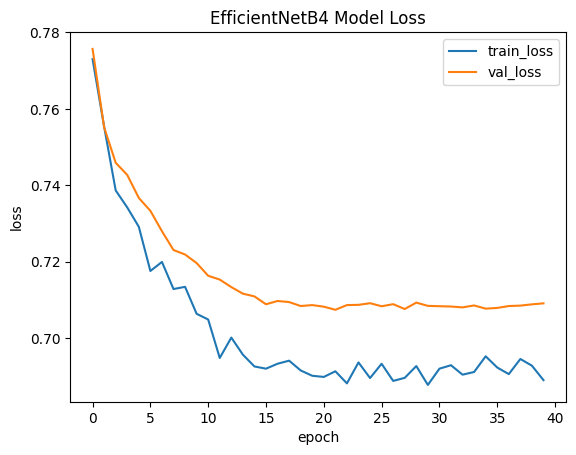

In [35]:
plt.plot(efficientnet_b4_history.history['loss'])
plt.plot(efficientnet_b4_history.history['val_loss'])
plt.title('EfficientNetB4 Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss','val_loss'])
plt.show()

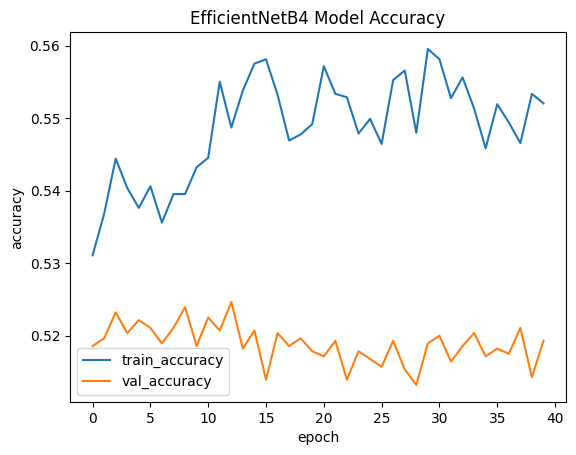

In [36]:
plt.plot(efficientnet_b4_history.history['Accuracy'])
plt.plot(efficientnet_b4_history.history['val_Accuracy'])
plt.title('EfficientNetB4 Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

# Conclusion

Finetuning an EfficientNetB4 gave the best results and could give even more better results if it is run for more Epochs and with a lower Learning-Rate.